In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [24]:
# Loading the data as a pandas dataframe
df = pd.read_csv('/content/drive/MyDrive/bootcampdata/tmaxdata.csv',names=["state_code", "date", "value"])
df = df[df['state_code'] == 'MN']
df.drop(["state_code"],inplace=True,axis=1)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,value
8030,1905-01-01,10.0
8031,1905-01-02,10.0
8032,1905-01-03,7.2
8033,1905-01-04,5.0
8034,1905-01-05,1.1
...,...,...
2078456,2018-12-27,4.4
2078457,2018-12-28,7.8
2078458,2018-12-29,7.2
2078459,2018-12-30,1.7


In [25]:
# Convert the data values to numpy for better and faster processing
time_index = np.array(df['date'])
data = np.array(df['value'])


In [26]:
time_index

array(['1905-01-01', '1905-01-02', '1905-01-03', ..., '2018-12-29',
       '2018-12-30', '2018-12-31'], dtype=object)

In [27]:
data

array([10. , 10. ,  7.2, ...,  7.2,  1.7,  2.2])

In [35]:
# Certain Hyper-parameters to tune
SPLIT_RATIO = 0.99
WINDOW_SIZE = 60
BATCH_SIZE = 32
SHUFFLE_BUFFER = 1000

# Dividing into train-test split
split_index = int(SPLIT_RATIO * data.shape[0])


# Train-Test Split
train_data = data[:split_index]
train_time = time_index[:split_index]

test_data = data[split_index:]
test_time = time_index[split_index:]

In [37]:
data.shape[0]

41638

In [38]:
def ts_data_generator(data, window_size, batch_size, shuffle_buffer):
  '''
  Utility function for time series data generation in batches
  '''
  ts_data = tf.data.Dataset.from_tensor_slices(data)
  ts_data = ts_data.window(window_size + 1, shift=1, drop_remainder=True)
  ts_data = ts_data.flat_map(lambda window: window.batch(window_size + 1))
  ts_data = ts_data.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  ts_data = ts_data.batch(batch_size).prefetch(1)
  return ts_data

In [39]:
train_dataset = ts_data_generator(train_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
test_dataset = ts_data_generator(test_data, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=[WINDOW_SIZE], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9))
model.fit(train_dataset, epochs=200,validation_data = test_dataset)

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1287/1287 [==============================] - 11s 8ms/step - loss: 38.1915 - val_loss: 29.2615
Epoch 2/200
1287/1287 [==============================] - 9s 7ms/step - loss: 32.5352 - val_loss: 26.9371
Epoch 3/200
1287/1287 [==============================] - 10s 8ms/step - loss: 30.4217 - val_loss: 25.3806
Epoch 4/200
1287/1287 [==============================] - 10s 8ms/step - loss: 28.8683 - val_loss: 24.1682
Epoch 5/200
1287/1287 [==============================] - 9s 7ms/step - loss: 27.6292 - val_loss: 23.1767
Epoch 6/200
1287/1287 [==============================] - 11s 9ms/step - loss: 26.6248 - val_loss: 22.3982
Epoch 7/200
1287/1287 [==============================] - 11s 9ms/step - loss: 25.7682 - val_loss: 21.6340
Epoch 8/200
1287/1287 [==============================] - 11s 8ms/step - loss: 25.0164 - val_loss: 20.9744
Epoch 9/200
1287/1287 [==============================] - 9s 7ms/step - loss: 24.3475 - val_loss: 20.3304
Epoch 10/200
1287/1287 [==============================] - 10s

In [41]:
forecast=[]
for time in range(len(data) - WINDOW_SIZE):
  forecast.append(model.predict(data[time:time + WINDOW_SIZE][np.newaxis]))

forecast = forecast[split_index-WINDOW_SIZE:]
results = np.array(forecast)[:, 0, 0]


# Overall Error
error = tf.keras.metrics.mean_absolute_error(test_data, results).numpy()
print(error)
# 16.528038

2.3522327


In [42]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

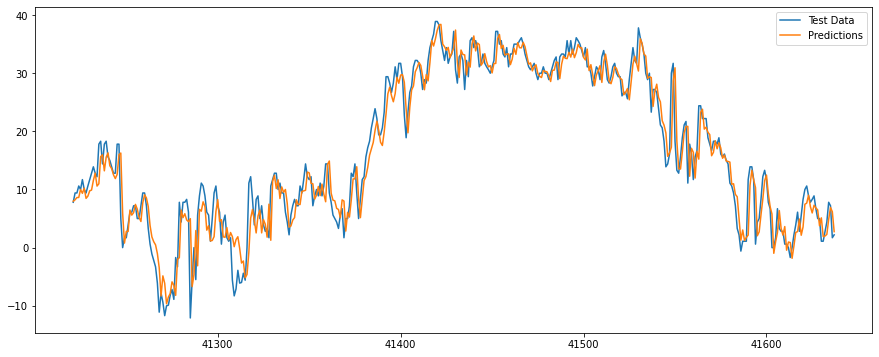

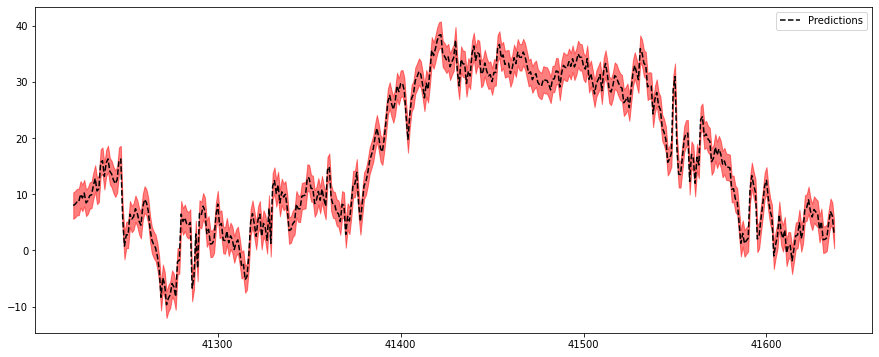

In [43]:
plt.figure(figsize=(15, 6))

plt.plot(list(range(split_index,len(data))), test_data, label = 'Test Data')
plt.plot(list(range(split_index,len(data))), results, label = 'Predictions')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
# Plotting with Confidence Intervals
plt.plot(list(range(split_index,len(data))), results, label = 'Predictions', color = 'k', linestyle = '--')
plt.fill_between(range(split_index,len(data)), results - error, results + error, alpha = 0.5, color = 'red')
plt.legend()
plt.show()